# **라이브러리**

In [59]:
!pip install koreanize-matplotlib

In [60]:
!pip install konlpy

In [61]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 42.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [62]:
import koreanize_matplotlib

In [63]:
import pandas as pd
from konlpy.tag import Okt
from collections import Counter
import itertools
import networkx as nx
import matplotlib.pyplot as plt

In [64]:
import pandas as pd

# 파일 경로
file_paths = [
    "/content/drive/MyDrive/tour/크롤링/박물관/andong_museum.csv",
    "/content/drive/MyDrive/tour/크롤링/박물관/andong_village.csv",
    "/content/drive/MyDrive/tour/크롤링/박물관/gyeongju_museum.csv",
    "/content/drive/MyDrive/관광공모전/historic_site.csv"
]

# 각 CSV 파일 불러오기
df_list = [pd.read_csv(path) for path in file_paths]

# 하나로 합치기
review = pd.concat(df_list, ignore_index=True)
display(review)


,review
0,The visit is relatively quick and interesting ...
1,The focus on Hahoe Masks could be amplified. T...
2,Free museum. Small museum to absolutely visit ...
3,I thought it would be a simple Korean traditio...
4,This museum is near to the ticket office of Ha...
...,...
1004,well preserved large complex of historic struc...
1005,Historically place Must go there in April and ...
1006,Fascinating temple in lovely setting This was ...
1007,Well worth a visit Gyeongju is a very attracti...


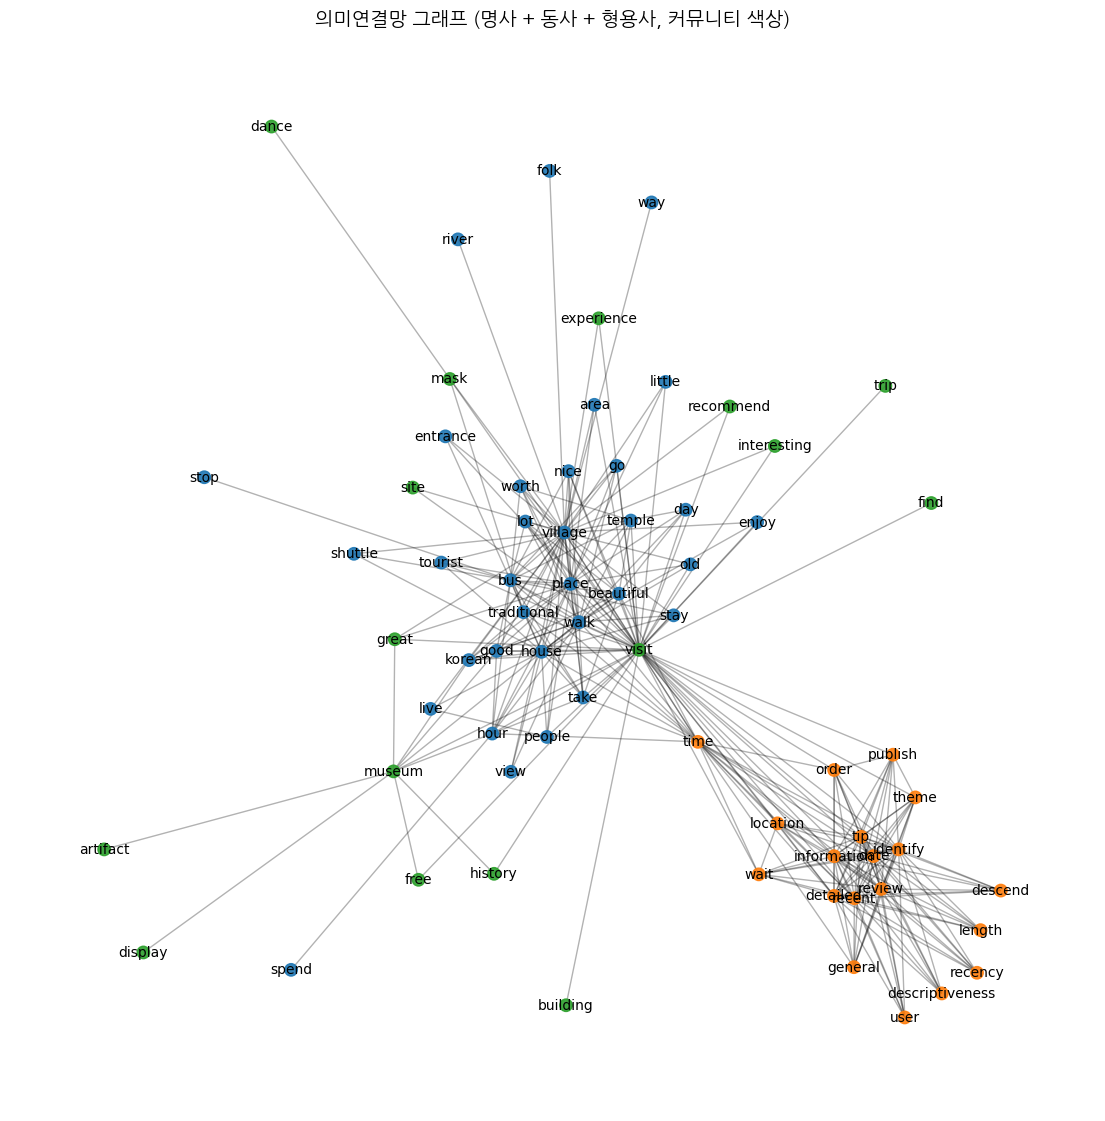

In [65]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
from networkx.algorithms.community import greedy_modularity_communities

# 영어 리뷰 대상이므로 영어 모델 사용
nlp = spacy.load("en_core_web_sm")

# 전처리 함수: 명사, 동사, 형용사만 추출
def extract_meaningful_words(text):
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc
            if token.pos_ in ['NOUN', 'VERB', 'ADJ']
            and not token.is_stop and token.is_alpha]

# 1. 리뷰 전체 문장에서 단어쌍 추출
texts = review['review'].dropna().tolist()
co_occur_pairs = []
for sentence in texts:
    words = list(set(extract_meaningful_words(sentence)))
    co_occur_pairs += list(combinations(words, 2))

# 2. 상위 단어쌍 추출
pair_counts = Counter(co_occur_pairs)
top_pairs = pair_counts.most_common(300)

# 3. 의미연결망 생성
G = nx.Graph()
for (w1, w2), freq in top_pairs:
    G.add_edge(w1, w2, weight=freq)

# 4. 커뮤니티 탐색
communities = list(greedy_modularity_communities(G))
community_map = {}
for i, com in enumerate(communities):
    for word in com:
        community_map[word] = i

# 5. 색상 매핑
color_list = plt.cm.tab10.colors  # 최대 10개 커뮤니티 색상
node_colors = [color_list[community_map[node] % len(color_list)] for node in G.nodes()]

# 6. 시각화
plt.figure(figsize=(14, 14))
pos = nx.spring_layout(G, seed=42, k=0.3)  # 레이아웃 고정
nx.draw_networkx_nodes(G, pos, node_size=80, node_color=node_colors, alpha=0.9)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("의미연결망 그래프 (명사 + 동사 + 형용사, 커뮤니티 색상)", fontsize=14)
plt.axis('off')
plt.show()


In [66]:
# 먼저 영어 감성 분석을 위해 nltk의 Vader 설치 및 로딩
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# 감성 분석기 초기화
sid = SentimentIntensityAnalyzer()

# 감성 점수 계산 함수
def get_sentiment_score(text):
    if pd.isnull(text) or not isinstance(text, str):
        return None
    return sid.polarity_scores(text)['compound']

# 감성 점수 계산 및 추가
review['sentiment_score'] = review['review'].apply(get_sentiment_score)

# 감성 레이블 부여: 긍정 / 중립 / 부정
def label_sentiment(score):
    if score is None:
        return 'neutral'
    elif score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

review['sentiment_label'] = review['sentiment_score'].apply(label_sentiment)

# 결과 미리 보기
review[['review', 'sentiment_score', 'sentiment_label']].head()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,review,sentiment_score,sentiment_label
0,The visit is relatively quick and interesting ...,0.2500,positive
1,The focus on Hahoe Masks could be amplified. T...,0.0000,neutral
2,Free museum. Small museum to absolutely visit ...,0.6901,positive
3,I thought it would be a simple Korean traditio...,0.7574,positive
4,This museum is near to the ticket office of Ha...,0.6808,positive


/tmp/ipython-input-67-445784590.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=review, x='sentiment_label', order=['positive', 'neutral', 'negative'], palette='Set2')


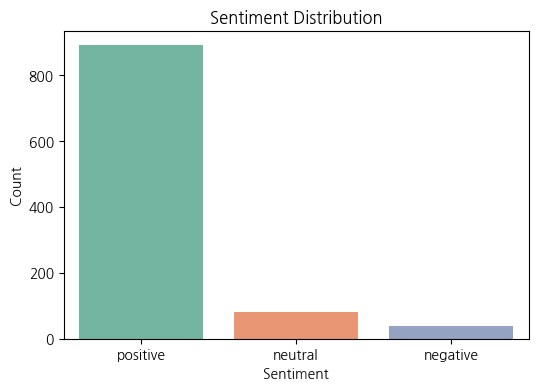

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=review, x='sentiment_label', order=['positive', 'neutral', 'negative'], palette='Set2')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


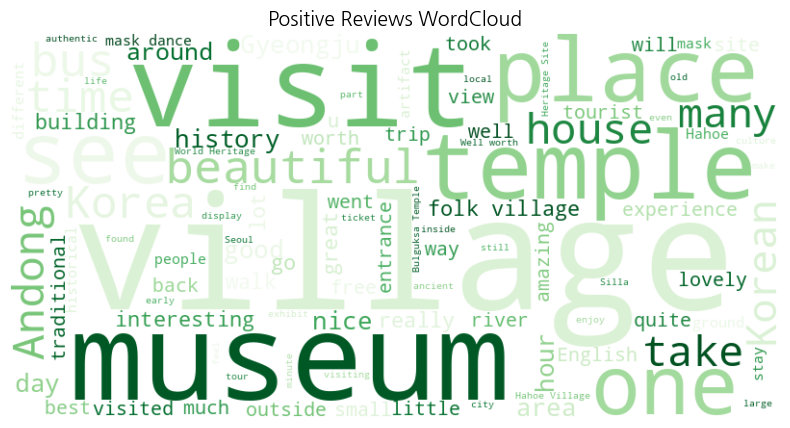

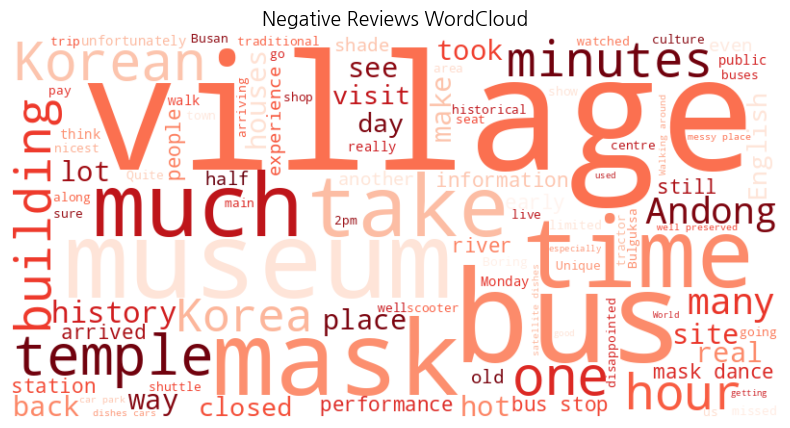

In [68]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# 전처리 함수 (단어만 추출)
def get_wordcloud_text(df, sentiment_label):
    texts = df[df['sentiment_label'] == sentiment_label]['review'].dropna().tolist()
    return " ".join(texts)

from wordcloud import WordCloud

# 긍정/부정 리뷰 텍스트 결합
positive_text = " ".join(review[review['sentiment_label'] == 'positive']['review'].dropna().tolist())
negative_text = " ".join(review[review['sentiment_label'] == 'negative']['review'].dropna().tolist())

# 워드클라우드 그리기 함수
def draw_wordcloud_colormap(text, title, colormap):
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          max_words=100, colormap=colormap).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.show()

# 긍정 리뷰 워드클라우드 (초록색 계열)
draw_wordcloud_colormap(positive_text, "Positive Reviews WordCloud", colormap='Greens')

# 부정 리뷰 워드클라우드 (빨간색 계열)
draw_wordcloud_colormap(negative_text, "Negative Reviews WordCloud", colormap='Reds')


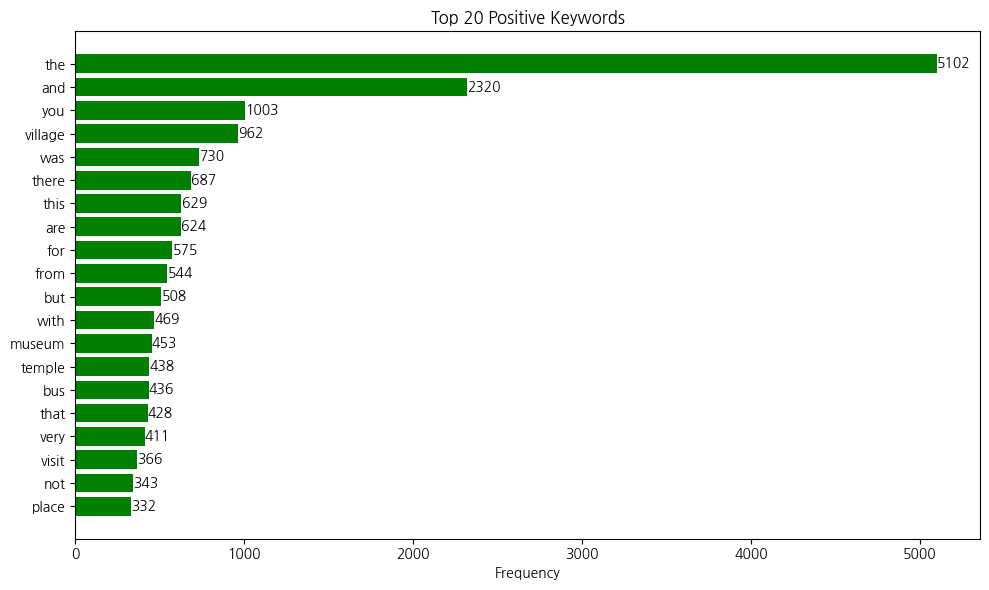

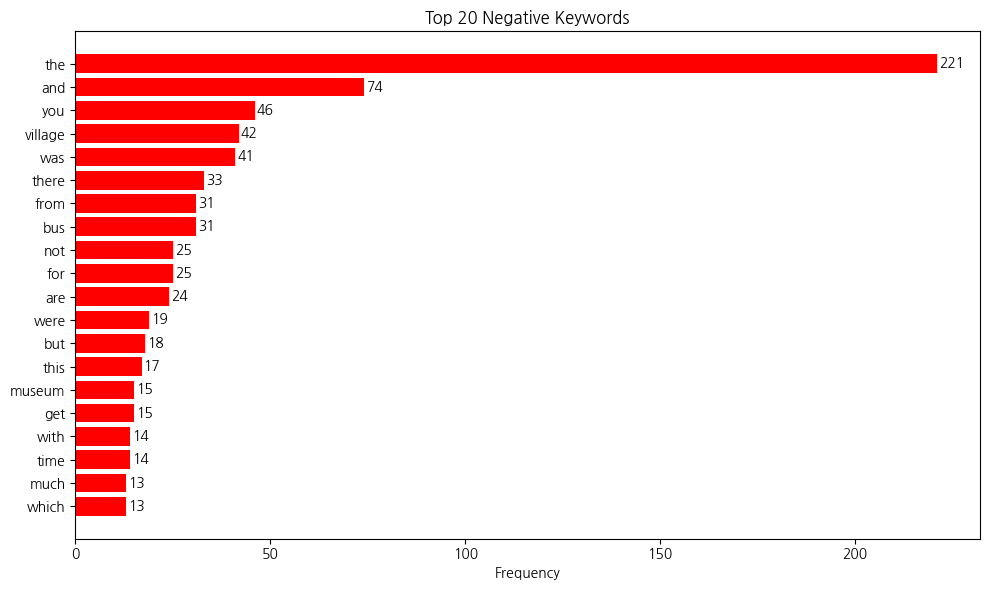

In [69]:
# 긍정/부정 리뷰 텍스트 수집
positive_reviews = review[review['sentiment_label'] == 'positive']['review'].dropna().tolist()
negative_reviews = review[review['sentiment_label'] == 'negative']['review'].dropna().tolist()

# 간단한 전처리: 소문자 + 알파벳만 추출
import re
from collections import Counter

def tokenize(text_list):
    words = []
    for text in text_list:
        tokens = re.findall(r'\b[a-z]{3,}\b', text.lower())  # 3자 이상 영문자만
        words.extend(tokens)
    return words

# 토큰화 및 단어 빈도수 계산
positive_words = tokenize(positive_reviews)
negative_words = tokenize(negative_reviews)

positive_counts = Counter(positive_words)
negative_counts = Counter(negative_words)

# 상위 20개 키워드 추출
top_pos = positive_counts.most_common(20)
top_neg = negative_counts.most_common(20)

# 데이터프레임으로 변환
df_pos = pd.DataFrame(top_pos, columns=['Keyword', 'Frequency'])
df_neg = pd.DataFrame(top_neg, columns=['Keyword', 'Frequency'])

# 시각화: 긍정 키워드
plt.figure(figsize=(10, 6))
bars = plt.barh(df_pos['Keyword'][::-1], df_pos['Frequency'][::-1], color='green')
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f'{int(bar.get_width())}', va='center')
plt.title("Top 20 Positive Keywords")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

# 시각화: 부정 키워드
plt.figure(figsize=(10, 6))
bars = plt.barh(df_neg['Keyword'][::-1], df_neg['Frequency'][::-1], color='red')
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f'{int(bar.get_width())}', va='center')
plt.title("Top 20 Negative Keywords")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()


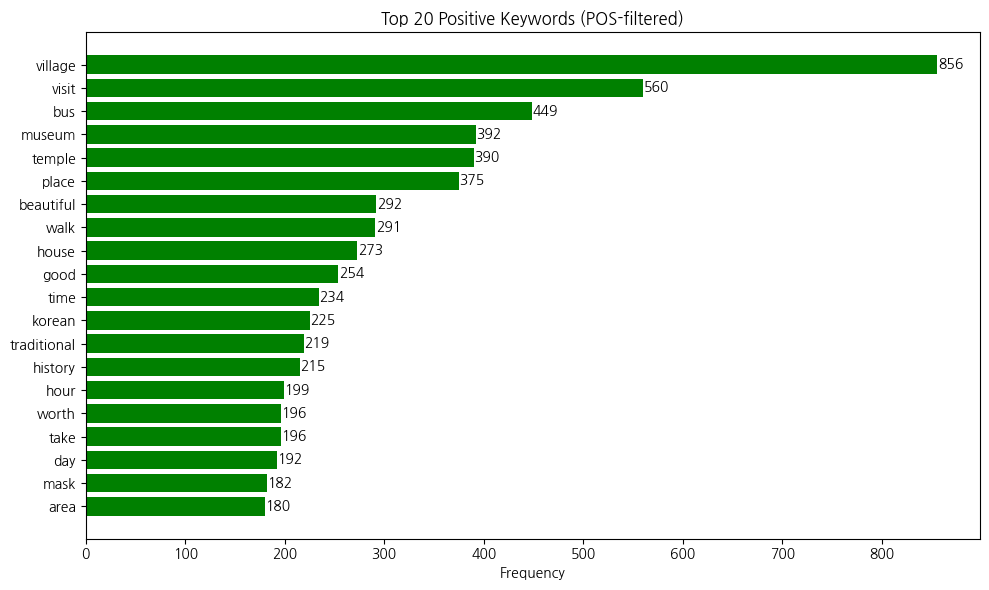

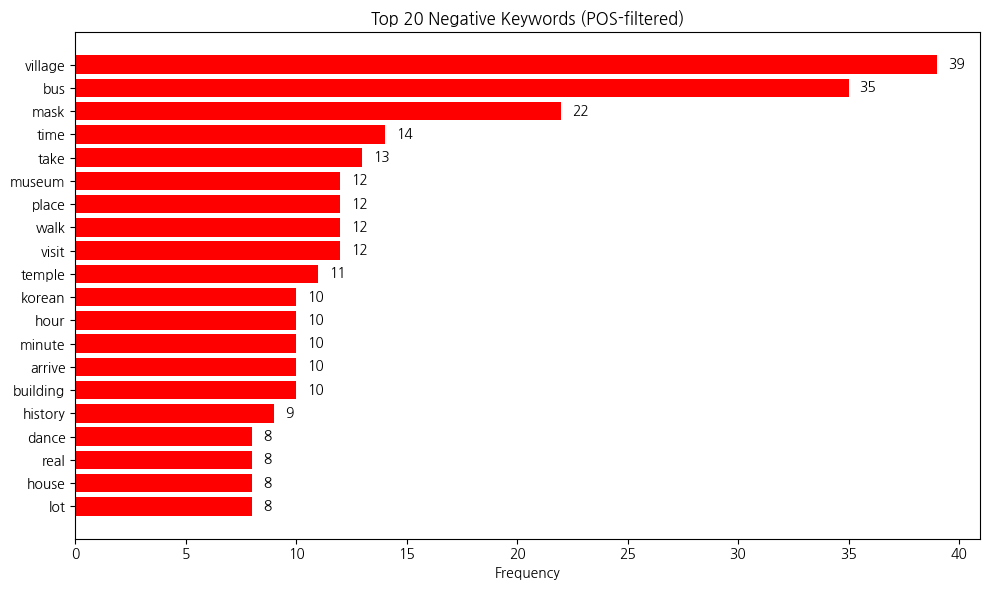

In [70]:
# 4. spaCy 로드 및 형태소 추출 함수 (명사/동사/형용사 + 불용어 제거)
nlp = spacy.load("en_core_web_sm")

def extract_meaningful_words(text_list):
    words = []
    for doc in nlp.pipe(text_list):
        words += [
            token.lemma_.lower() for token in doc
            if token.pos_ in ['NOUN', 'VERB', 'ADJ']
            and not token.is_stop and token.is_alpha
        ]
    return words

# 5. 감성별 단어 리스트 생성
positive_reviews = review[review['sentiment_label'] == 'positive']['review'].dropna().tolist()
negative_reviews = review[review['sentiment_label'] == 'negative']['review'].dropna().tolist()

positive_words = extract_meaningful_words(positive_reviews)
negative_words = extract_meaningful_words(negative_reviews)

# 6. 상위 20개 키워드 추출
positive_counts = Counter(positive_words)
negative_counts = Counter(negative_words)

df_pos = pd.DataFrame(positive_counts.most_common(20), columns=['Keyword', 'Frequency'])
df_neg = pd.DataFrame(negative_counts.most_common(20), columns=['Keyword', 'Frequency'])

# 7. 막대그래프 시각화
def plot_keyword_bar(df, color, title):
    plt.figure(figsize=(10, 6))
    bars = plt.barh(df['Keyword'][::-1], df['Frequency'][::-1], color=color)
    for bar in bars:
        plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                 f'{int(bar.get_width())}', va='center')
    plt.title(title)
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_keyword_bar(df_pos, color='green', title='Top 20 Positive Keywords (POS-filtered)')
plot_keyword_bar(df_neg, color='red', title='Top 20 Negative Keywords (POS-filtered)')

## villiage, museum 제거

In [71]:
# 6. spaCy 로드 + 사용자 불용어 정의
nlp = spacy.load("en_core_web_sm")
custom_stopwords = {'museum', 'museums', 'village', 'villages', 'hahoe', 'andong', 'gyeongju'}

In [72]:
# 7. 품사 필터링 + 불용어 제거 함수
def extract_meaningful_words(text_list):
    words = []
    for doc in nlp.pipe(text_list):
        words += [
            token.lemma_.lower() for token in doc
            if token.pos_ in ['NOUN', 'VERB', 'ADJ']
            and not token.is_stop
            and token.is_alpha
            and token.lemma_.lower() not in custom_stopwords
        ]
    return words

# 8. 감성별 리뷰 텍스트 수집
positive_reviews = review[review['sentiment_label'] == 'positive']['review'].dropna().tolist()
negative_reviews = review[review['sentiment_label'] == 'negative']['review'].dropna().tolist()

# 9. 전처리 후 단어 추출
positive_words = extract_meaningful_words(positive_reviews)
negative_words = extract_meaningful_words(negative_reviews)

positive_counts = Counter(positive_words)
negative_counts = Counter(negative_words)


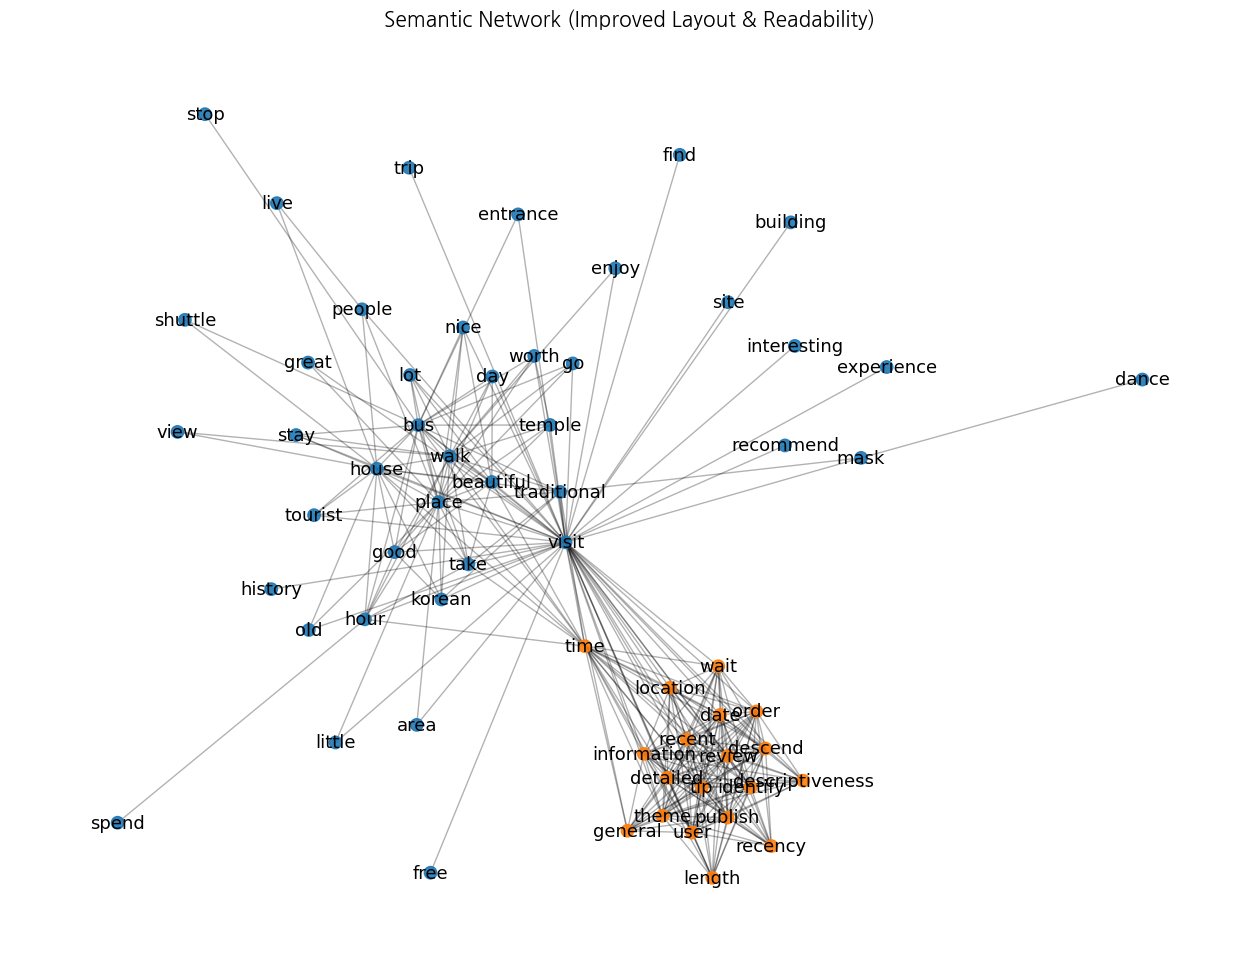

In [73]:
# 리뷰에서 단어쌍 생성 (각 문장별 공기출현 기반)
texts = review['review'].dropna().tolist()
co_occur_pairs = []

for sentence in texts:
    tokens = list(set(extract_meaningful_words([sentence])))
    co_occur_pairs += list(combinations(tokens, 2))

# 상위 연관 단어쌍 추출
pair_counts = Counter(co_occur_pairs)
top_pairs = pair_counts.most_common(300)  # 상위 300쌍

# 의미연결망 그래프 구성
G = nx.Graph()
for (w1, w2), freq in top_pairs:
    G.add_edge(w1, w2, weight=freq)

# 커뮤니티 탐지
communities = list(greedy_modularity_communities(G))
community_map = {}
for i, com in enumerate(communities):
    for word in com:
        community_map[word] = i

# 노드별 색상 할당
color_list = plt.cm.tab10.colors
node_colors = [color_list[community_map[node] % len(color_list)] for node in G.nodes()]

# 시각화
# 개선된 시각화 코드 일부
pos = nx.spring_layout(G, seed=42, k=0.5)  # 더 넓게 퍼지도록

plt.figure(figsize=(16, 12))
nx.draw_networkx_nodes(G, pos, node_size=80, node_color=node_colors, alpha=0.9)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=13)
plt.title("Semantic Network (Improved Layout & Readability)", fontsize=15)
plt.axis('off')
plt.show()


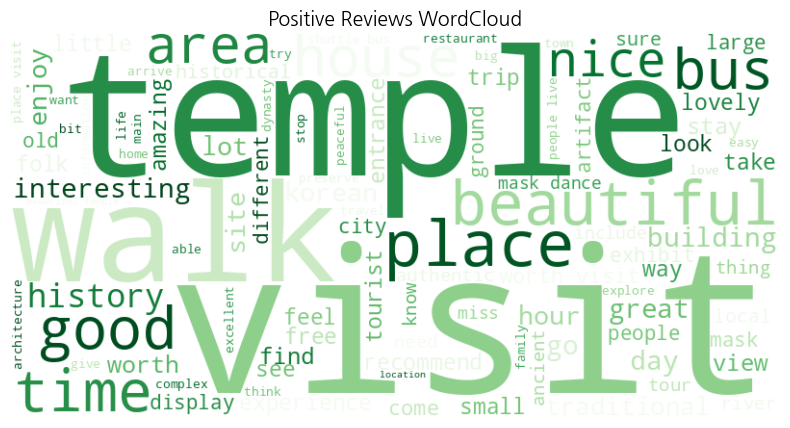

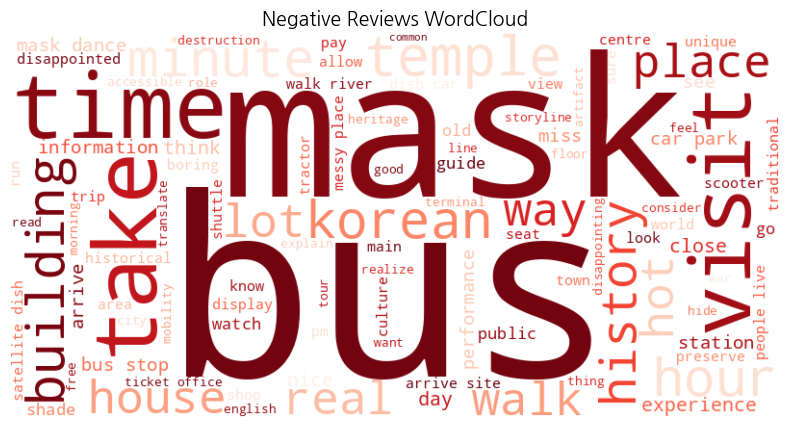

In [74]:
# 10. 감성별 워드클라우드 시각화
def draw_wordcloud(words, title, colormap):
    text = " ".join(words)
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          colormap=colormap, max_words=100).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.show()

draw_wordcloud(positive_words, "Positive Reviews WordCloud", colormap='Greens')
draw_wordcloud(negative_words, "Negative Reviews WordCloud", colormap='Reds')


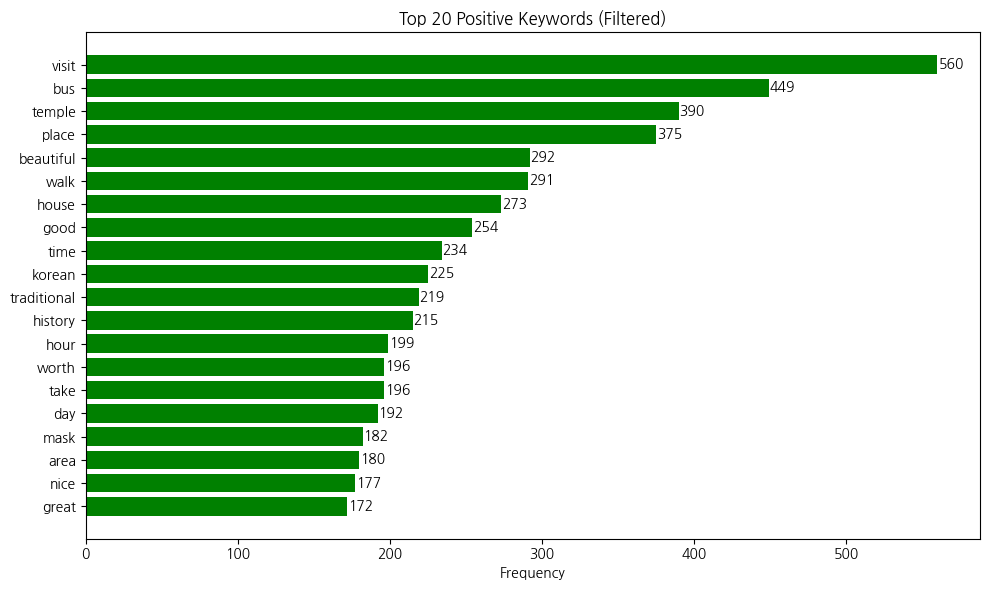

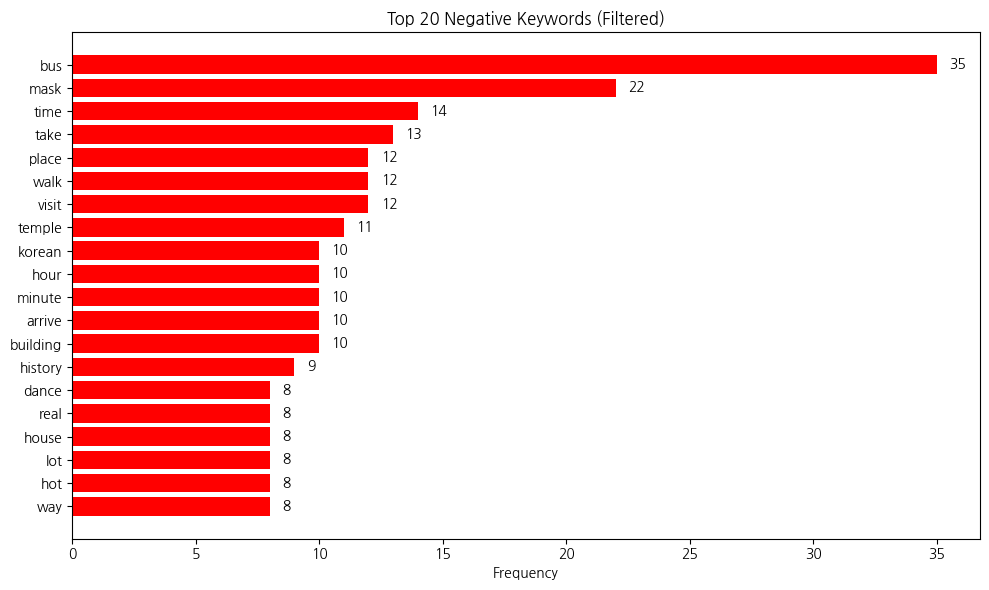

In [75]:
# 11. 감성별 키워드 막대그래프
def plot_keyword_bar(counter_data, color, title):
    top_keywords = counter_data.most_common(20)
    df = pd.DataFrame(top_keywords, columns=['Keyword', 'Frequency'])
    plt.figure(figsize=(10, 6))
    bars = plt.barh(df['Keyword'][::-1], df['Frequency'][::-1], color=color)
    for bar in bars:
        plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                 f'{int(bar.get_width())}', va='center')
    plt.title(title)
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_keyword_bar(positive_counts, 'green', 'Top 20 Positive Keywords (Filtered)')
plot_keyword_bar(negative_counts, 'red', 'Top 20 Negative Keywords (Filtered)')

In [76]:
# 1. 설치 및 불용어 사전 정의
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
from itertools import combinations
import matplotlib.colors as mcolors

# 3. spaCy 로딩 & 불용어 정의
nlp = spacy.load("en_core_web_sm")
custom_stopwords = {'museum', 'village', 'hahoe', 'andong', 'gyeongju', 'place', 'visit'}

def extract_tokens(text):
    doc = nlp(str(text))
    return [
        token.lemma_.lower()
        for token in doc
        if token.pos_ in ['NOUN', 'VERB', 'ADJ']
        and not token.is_stop
        and token.is_alpha
        and token.lemma_.lower() not in custom_stopwords
    ]



In [77]:
# 4. 📥 데이터 불러오기
# (1) 리뷰 데이터
file_paths = {
    "/content/drive/MyDrive/tour/크롤링/박물관/andong_museum.csv": "Andong Museum",
    "/content/drive/MyDrive/tour/크롤링/박물관/andong_village.csv": "Hahoe Village",
    "/content/drive/MyDrive/tour/크롤링/박물관/gyeongju_museum.csv": "Gyeongju Museum",
    "/content/drive/MyDrive/tour/크롤링/유적지/bulguksa.csv": "Bulguksa"
}

df_list = []
for path, place in file_paths.items():
    df = pd.read_csv(path)
    df["place"] = place
    df_list.append(df)

review = pd.concat(df_list, ignore_index=True)

# (2) 설문 데이터
df_2024 = pd.read_excel("/content/drive/MyDrive/tour/data/elsx/2024 외래관광객조사_Data.xlsx")

In [78]:
# 5. Q13 재방문의향 계산 (가중평균)
place_map = {
    47004.0: "Bulguksa",
    47001.0: "Hahoe Village",
    47020.0: "Gyeongju Museum",
    47916.0: "Andong Museum"
}
df_2024["place"] = df_2024["Q9_1_1"].map(place_map)

def weighted_avg(series, weights):
    mask = series.notna() & weights.notna()
    return np.average(series[mask], weights=weights[mask]) if mask.sum() > 0 else None

place_q13 = (
    df_2024[["place", "Q13", "weight"]]
    .dropna()
    .groupby("place", group_keys=False)
    .apply(lambda g: pd.Series({"q13_mean": weighted_avg(g["Q13"], g["weight"])}))
    .reset_index()
)

/tmp/ipython-input-78-527474898.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({"q13_mean": weighted_avg(g["Q13"], g["weight"])}))


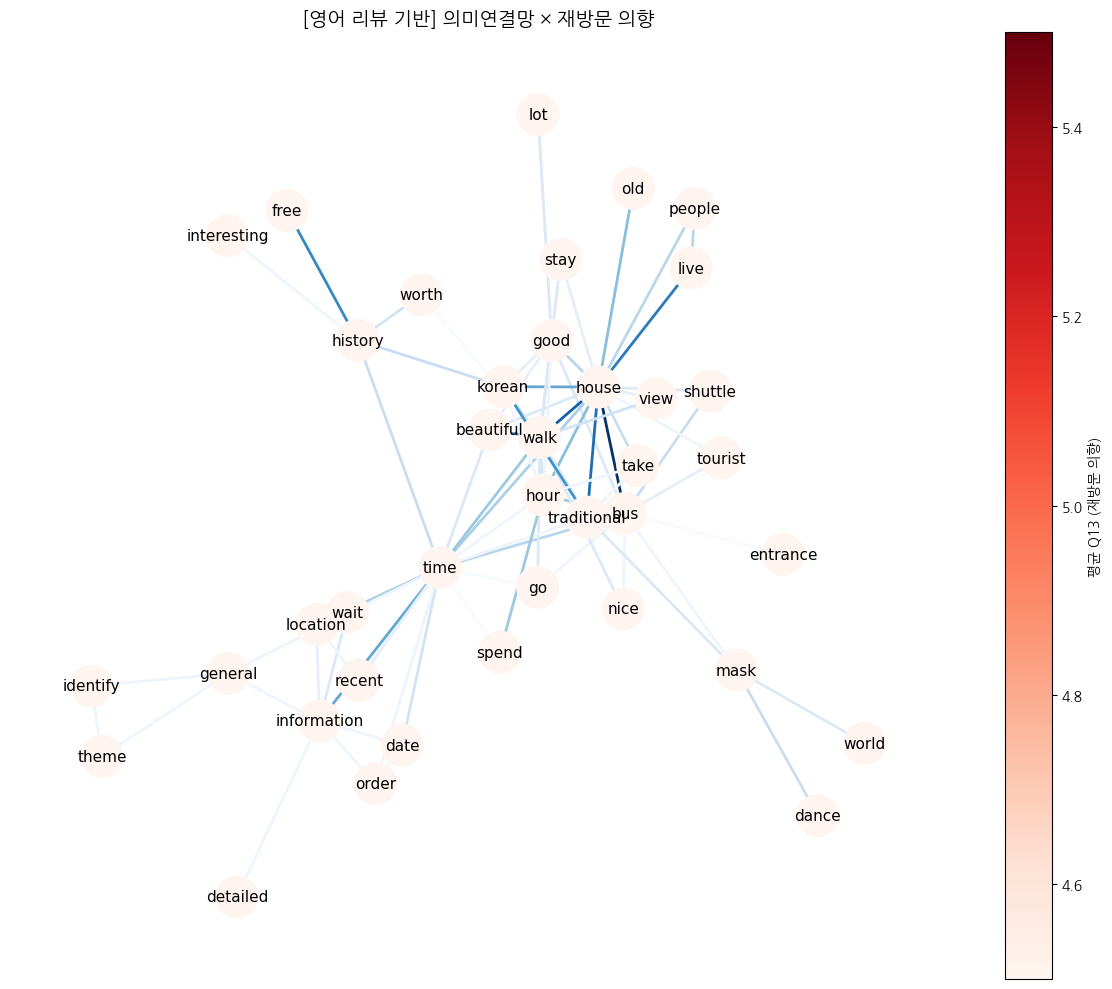

In [79]:
# 6. 리뷰 데이터에 q13 병합 + tokens 생성
review = review.merge(place_q13, on="place", how="left")
review["tokens"] = review["review"].apply(extract_tokens)

# 7. 의미연결망 시각화 함수
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
from itertools import combinations
import matplotlib.colors as mcolors

def plot_network_with_q13_reviews(df, top_n=80):
    # 1. 단어쌍 추출 및 Q13 가중치 수집
    cooccurrence = []
    word_q13 = []

    for _, row in df.iterrows():
        tokens = row["tokens"]
        q13 = row["q13_mean"]
        if isinstance(tokens, list) and len(tokens) >= 2:
            tokens = list(set(tokens))  # 중복 제거
            cooccurrence += list(combinations(tokens, 2))
            for word in tokens:
                word_q13.append((word, q13))

    # 2. 출현 빈도 높은 단어쌍 선정
    pair_counts = Counter(cooccurrence).most_common(top_n)

    if not pair_counts:
        print("⚠️ 단어쌍이 충분하지 않아 네트워크를 생성할 수 없습니다.")
        return

    # 3. 단어별 Q13 평균 계산
    df_word_q13 = pd.DataFrame(word_q13, columns=["word", "q13"])
    word_avg_q13 = df_word_q13.groupby("word")["q13"].mean().to_dict()

    # 4. 그래프 구성
    G = nx.Graph()
    for (w1, w2), count in pair_counts:
        G.add_edge(w1, w2, weight=count)

    pos = nx.spring_layout(G, k=0.5, seed=42)
    weights = [d["weight"] for _, _, d in G.edges(data=True)]
    node_colors = [word_avg_q13.get(n, 4.5) for n in G.nodes()]  # 기본값 4.5

    # 5. 시각화
    fig, ax = plt.subplots(figsize=(12, 10))

    nx.draw(
        G, pos, ax=ax, with_labels=True, node_size=900, font_size=11,
        edge_color=weights, edge_cmap=plt.cm.Blues, width=2,
        edge_vmin=min(weights), edge_vmax=max(weights),
        node_color=node_colors, cmap=plt.cm.Reds
    )

    # 🎯 colorbar를 위한 명확한 정규화 설정
    norm = mcolors.Normalize(vmin=min(node_colors), vmax=max(node_colors))
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("평균 Q13 (재방문 의향)")

    ax.set_title("[영어 리뷰 기반] 의미연결망 × 재방문 의향", fontsize=14)
    plt.tight_layout()
    plt.show()



# ✅ 실행
plot_network_with_q13_reviews(review, top_n=80)